In [ ]:
using JuMP, MosekTools
using Plots, Combinatorics, LinearAlgebra
using DelimitedFiles
using PoissonRandom
using NPZ
using Ipopt
include("quantumnpa-scalar_extension/QuantumNPA.jl");
using .QuantumNPA

In [ ]:
using Base.Threads
nthreads()

# Common definitions

In [1]:

function get_proj(obs)
    vals, vecs = eigen(obs)
    if vals[1] ≈ -1 && vals[2] ≈ 1
        return [vecs[:,2]*vecs[:,2]', vecs[:,1]*vecs[:,1]']
    elseif vals[1] ≈ 1 && vals[1] ≈ -1
        return [vecs[:,1]*vecs[:,1]', vecs[:,2]*vecs[:,2]']
    else
        throw("Non dichotomic observable: Eigenvalues: $vals.")
    end
end

function _cyclic_mon(P, n, x1, x2)
    m = Id
    for (i, x) in enumerate(Iterators.cycle([x1, x2]))
        m *= P[1, x]
        i ≥ n && break
    end
    return m
end

function generate_projective_scvar(P, N, x1, x2; tail=Id, swapped=true, var_symbols=nothing)
    vars = []
    for n=2:N
        Pn12 = _cyclic_mon(P, n, x1, x2)*tail
        if isnothing(var_symbols)
            αn12 = scalarfactor(Pn12)
        else
            αn12 = scalarfactor("$(var_symbols[1])_$(n)", Pn12)
        end
        push!(vars, αn12)
        if swapped 
            Pn21 = _cyclic_mon(P, n, x2, x1)*tail
            if isnothing(var_symbols)
                αn21 = scalarfactor(Pn21)
            else
                αn21 = scalarfactor("$(var_symbols[2])_$(n)", Pn21)
            end
            push!(vars, αn21)
        end
    end
    return vars
end

function generate_projective_scvar(P, N; tail=Id, swapped=true, var_symbols=nothing)
    num_settings = size(PA)[2]
    vars = []
    for (x1, x2) in combinations(1:num_settings, 2)
        if !isnothing(var_symbols)
            var_symbols = map(s->"$s$x1$x2", var_symbols)
        end
        push!(vars, generate_projective_scvar(P, N, x1, x2, tail=tail, swapped=swapped, var_symbols=var_symbols)...)
    end
    return vars
end

"""Search for the minimum value inside `interval` for which `f(x)` is true.
Returns an interval such that `x_min ∈ [x1, x2]`.""" 
function min_binary_search(f::Function, interval::Tuple{Float64, Float64}, N::Int; verbose=false)
    min_int = [interval...]
    for i=1:N
        x = sum(min_int)/2
        verbose && print("\rChecking interval $min_int")
        if f(x)
            min_int[2] = x
        else
            min_int[1] = x
        end
    end
    verbose && println()
    return min_int
end




min_binary_search

In [2]:

function bell_state(n; θ=π/4)
    bell_vec = [[cos(θ), 0, 0, sin(θ)], [cos(θ), 0, 0, -sin(θ)], [0, cos(θ), sin(θ), 0], [0, cos(θ), -sin(θ), 0]]
    bell_state_list = [v*v' for v in bell_vec]
    return Complex.(bell_state_list[n])
end

function eye(n)
    return 1* Matrix(I, n, n)
end

σx = Matrix([[0, 1] [1, 0]])
σy = Matrix([[0, 1im]  [-1im, 0]])
σz = Matrix([[1, 0] [0, -1]])
σ = [σx, σy, σz];

## Definitions

### Strategy definitions

In [3]:
ide = [1 0; 0 1]
II = kron(ide, ide)

# State cos(θ)|00> + sin(θ)|11>
ψ = θ -> [cos(θ); 0; 0; sin(θ)]
ρwer = (θ,v) -> v*(ψ(θ) * ψ(θ)') + (1-v)*II/4

function gen_abxy_bell(v, θ; 
                 ρ=ρwer, 
                 obsA=[get_proj(σ[3]), get_proj(σ[1])], 
                 obsB=[get_proj((σ[1]+σ[3])/√2), get_proj((-σ[1]+σ[3])/√2)])
    p = zeros(2,2,2,2)
    state = ρ(θ,v)
    for (a,b,x,y) in Iterators.product(1:2, 1:2, 1:2, 1:2)
        p[a,b,x,y] = real(tr(state * kron(obsB[y][b], obsA[x][a])))
    end
    return p
end

# Tilted Tony
μ(α, θ) = atan(sin(2θ/α))
PA_atilted = [get_proj(σ[3]),
              get_proj(σ[1])]
PB_atilted(α, θ) = [get_proj(cos(μ(α,θ))*σ[3] + sin(μ(α,θ))*σ[1]),
                    get_proj(cos(μ(α,θ))*σ[3] - sin(μ(α,θ))*σ[1])]

function gen_abxy_atilted(v, θ, α)
    return gen_abxy_bell(v, θ; 
                 ρ=ρwer, 
                 obsA=PA_atilted, 
                 obsB=PB_atilted(α, θ))
end

function bell_atilted_from_dist(p, α, β)
    ab(x,y) = sum(p[a,b,x,y] * (-1)^(a+b) for a=1:2, b=1:2)
    a(x) = sum(p[a,b,x,1] * (-1)^(a) for a=1:2, b=1:2)
    return β*a(1) + α*ab(1,1) + ab(2,1) + α*ab(1,2) - ab(2,2)
end

# Tilted Wooltorton 1
PA_wtilted1(δ) = [get_proj(σ[3]),
                  get_proj(-sin(δ)*σ[3] + cos(δ)*σ[1])]
PB_wtilted1(δ) = [get_proj(σ[1]),
                  get_proj(cos(δ)*σ[3] - sin(δ)*σ[1])]

function gen_abxy_wtilted1(v, δ; θ=π/4)
    return gen_abxy_bell(v, θ;
                 ρ=ρwer, 
                 obsA=PA_wtilted1(δ), 
                 obsB=PB_wtilted1(δ))
end

function p_bilocality_22_wtilted(δ; θ=π/4, v=1, id=1)
    A = ΠA_wtilted1(δ)
    C = ΠC_wtilted1(δ)
    B = [[kron(B1[1], B2[1]) + kron(B1[2], B2[2]),
          kron(B1[1], B2[2]) + kron(B1[2], B2[1])]
        for (B1, B2) in zip(C, A)]
    ρ = kron(ρ_bell(v, θ=θ, id=id),
             ρ_bell(v, θ=θ, id=id))
    return p_bilocality(A, B, C, ρ)
end

function bell_wtilted1_from_dist(p, δ)
    ab(x,y) = sum(p[a,b,x,y] * (-1)^(a+b) for a=1:2, b=1:2)
    return ab(1,1) + (ab(1,2) + ab(2,1))/sin(δ) - ab(2,2)/cos(2δ)
end

# Tilted Wooltorton 2
PA_wtilted2(γ) = [get_proj(σ[3]),
                  get_proj(cos(2π/3 - 2γ)*σ[3] + sin(2π/3 - 2γ)*σ[1])]
PB_wtilted2(γ) = [get_proj(sin(3γ)*σ[3] + cos(3γ)*σ[1]),
                  get_proj(cos(π/6 + γ)*σ[3] - sin(π/6 + γ)*σ[1])]

function gen_abxy_wtilted2(v, γ; θ=π/4)
    return gen_abxy_bell(v, θ;
                 ρ=ρwer, 
                 obsA=PA_wtilted2(γ), 
                 obsB=PB_wtilted2(γ))
end

function bell_wtilted2_from_dist(p, γ)
    ab(x,y) = sum(p[a,b,x,y] * (-1)^(a+b) for a=1:2, b=1:2)
    c = 4*cos(γ+π/6)^2-1 
    return ab(1,1) + c*(ab(1,2) + ab(2,1) - ab(2,2))
end

# Behavior constraints

function get_bconstraints(p)
    return [PA[1,1] - Id*sum(p[1,:,1,1]),
            PA[1,2] - Id*sum(p[1,:,2,1]),
            PB[1,1] - Id*sum(p[:,1,1,1]),
            PB[1,2] - Id*sum(p[:,1,1,2]),
            PA[1,1]*PB[1,1] - Id*p[1,1,1,1],
            PA[1,1]*PB[1,2] - Id*p[1,1,1,2],
            PA[1,2]*PB[1,1] - Id*p[1,1,2,1],
            PA[1,2]*PB[1,2] - Id*p[1,1,2,2]]
end

LoadError: UndefVarError: `eigen` not defined

# Quantum Bilocality

In [4]:
function generate_bilocal_eq_constraints(p, PA::Matrix{Any}, PB::Matrix{Any}, PC::Matrix{Any})
    nA, nX = size(PA)
    nC, nZ = size(PC)
    nB, nY = size(PB)
    eqs = [PA[a,x]*PB[b,y]*PC[c,z] - Id*p[a,b,c,x,y,z] 
        for (a,b,c,x,y,z) in Iterators.product(1:nA, 1:nB, 1:nC, 1:nX, 1:nY, 1:nZ)]
    eqs = [eqs...];
    
    return eqs
end

function generate_bilocal_eq_constraints(p, PA::Matrix{Any}, PB::Vector{Any}, PC::Matrix{Any})
    nA, nX = size(PA)
    nC, nZ = size(PC)
    nB = size(PB)[1]
    eqs = [PA[a,x]*PB[b]*PC[c,z] - Id*p[a,b,c,x,z]
        for (a,b,c,x,z) in Iterators.product(1:nA, 1:nB, 1:nC, 1:nX, 1:nZ)]
    eqs = [eqs...];
    
    return eqs
end

function bilo_is_feasible(p, PA, PB, PC; commutative=false, level=2)
    eqs = generate_bilocal_eq_constraints(p, PA, PB, PC)
    model = npa2jump(Id, level, se, eq=eqs, solver=Mosek.Optimizer, verbose=false)
    optimize!(model)
    return !is_solved_and_feasible(model)
end

function bilo_pguess(p, PA, PB, PC, PE, se; level=2, x=1, y=1, z=1, verbose=false)
    nA, nX = size(PA)
    nC, nZ = size(PC)
    nB = size(PB)[1]
    nE = size(PE)[1]
    
    eqs = generate_bilocal_eq_constraints(p, PA, PB, PC)
    
    # Select the correct pguess (guessing B or not) depending on the PE dimension
    if nE > nA*nC
        if length(size(PB)) > 1
            pguess = sum(PA[a,x]*PB[b,y]*PC[c,z]*PE[(a-1) + (b-1)*nA + (c-1)*nA*nB + 1] for (a,b,c) in Iterators.product(1:nA, 1:nB, 1:nC))
        else
            pguess = sum(PA[a,x]*PB[b]*PC[c,z]*PE[(a-1) + (b-1)*nA + (c-1)*nA*nB + 1] for (a,b,c) in Iterators.product(1:nA, 1:nB, 1:nC))
        end
    else
        pguess = sum(PA[a,x]*PC[c,z]*PE[(a-1) + (c-1)*nA + 1] for (a,c) in Iterators.product(1:nA, 1:nC))
    end
    
    model = npa2jump(pguess, level, se, eq=eqs, solver=Mosek.Optimizer, verbose=verbose)
    optimize!(model)
    return objective_value(model)
end

function bilo_pguess(p, PA, PB, PC, PE, PF, se; 
        level=2, x=1, y=1, z=1, 
        fb0 = b -> b%2,
        fb1 = b -> b÷2,
        verbose=false)
    nA, nX = size(PA)
    nC, nZ = size(PC)
    nB = size(PB)[1]
    nE = size(PE)[1]
    nF = size(PF)[1]
    
    eqs = generate_bilocal_eq_constraints(p, PA, PB, PC)
    
    # Select the correct pguess (guessing B or not) depending on the PE dimension
    if nE*nF > nA*nC
        if nB == 4
            if length(size(PB)) > 1
                pguess = sum(PA[a,x] * PB[b,y] * PC[c,z] * PE[(a-1)+fb0(b-1)*nA+1] * PF[(c-1)+fb1(b-1)*nC+1] 
                    for (a,b,c) in Iterators.product(1:nA, 1:nB, 1:nC))
            else
                pguess = sum(PA[a,x] * PB[b] * PC[c,z] * PE[(a-1)+fb0(b-1)*nA+1] * PF[(c-1)+fb1(b-1)*nC+1] 
                    for (a,b,c) in Iterators.product(1:nA, 1:nB, 1:nC))
            end
        elseif nB == 2
            if nE == 2 && nF == 4
                pguess = sum(PA[a,x] * PB[b] * PC[c,z] * PE[a] * PF[(c-1)+(b-1)*nC+1] 
                    for (a,b,c) in Iterators.product(1:nA, 1:nB, 1:nC))
            elseif nE == 4 && nF == 2
                pguess = sum(PA[a,x] * PB[b] * PC[c,z] * PE[(a-1)+(b-1)*nA+1] * PF[c]
                    for (a,b,c) in Iterators.product(1:nA, 1:nB, 1:nC))
            else
                throw("Invalid Eavesdropper dimensions")
            end 
        else
            throw("Only 1 or 2 bits central node is supported")
        end
    else
        pguess = sum(PA[a,x] * PC[c,z] * PE[a] * PF[c] 
            for (a,c) in Iterators.product(1:nA, 1:nC))
    end
    
    model = npa2jump(pguess, level, se, eq=eqs, solver=Mosek.Optimizer, verbose=verbose)
    optimize!(model)
    return objective_value(model)
end

function _ef_fun_generator()
    function _get_πfuncs(π)
        return b -> π[b+1] % 2, b -> π[b+1] ÷ 2
    end
    return map(_get_πfuncs, permutations([0,1,2,3]))
end

# No settings on B
function p_bilocality(A::Vector{Vector{Matrix{T}}}, 
                      B::Vector{Matrix{T}}, 
                      C::Vector{Vector{Matrix{T}}}, 
                      ρ::Matrix{T}) where T <: Complex
    num_outs = (length(A[1]), length(B), length(C[1]))
    num_sets = (length(A), length(C))
    p = zeros(num_outs..., num_sets...)
    for s in Iterators.product((1:n for n in num_sets)...)
        for o in Iterators.product((1:n for n in num_outs)...)
            ABC = kron(A[s[1]][o[1]], B[o[2]], C[s[2]][o[3]])
            p[o..., s...] = real(tr(ABC*ρ))
        end
    end
    return p
end

# B with settings
function p_bilocality(A::Vector{Vector{Matrix{T}}}, 
                      B::Vector{Vector{Matrix{T}}}, 
                      C::Vector{Vector{Matrix{T}}}, 
                      ρ::Matrix{T}) where T <: Complex
    num_outs = (length(A[1]), length(B[1]), length(C[1]))
    num_sets = (length(A), length(B), length(C))
    p = zeros(num_outs..., num_sets...)
    for s in Iterators.product((1:n for n in num_sets)...)
        for o in Iterators.product((1:n for n in num_outs)...)
            ABC = kron(A[s[1]][o[1]], B[s[2]][o[2]], C[s[3]][o[3]])
            p[o..., s...] = real(tr(ABC*ρ))
        end
    end
    return p
end

ρ2_bell(v1, v2; id=4) = kron(ρ_bell(v1, id=id), ρ_bell(v2, id=id))

σt(α1,α2) = [get_proj(sin(α1)*σ[3] + cos(α1)*σ[1]),
             get_proj(sin(α2)*σ[3] + cos(α2)*σ[1])]

ρ_bell(v; θ=π/4, id=4) = v*bell_state(id, θ=θ) + (1-v)*eye(4)/4

μ(α, θ) = atan(sin(2θ/α))
Π_atilted(α, θ) = [get_proj(cos(μ(α,θ))*σ[3] + sin(μ(α,θ))*σ[1]),
                  get_proj(cos(μ(α,θ))*σ[3] - sin(μ(α,θ))*σ[1])]

function p_bilocality_abell(;θ=π/4, v=1, α=1, id=4)
    
    B = [bell_state(k) for k=1:4]
    A = σt(0, π/2)
    C = Π_atilted(α, θ)
    ρ = kron(ρ_bell(v, θ=θ, id=id), 
             ρ_bell(v, θ=θ, id=id))
    return p_bilocality(A, B, C, ρ)
end

ΠA_wtilted1(δ) = [get_proj(σ[3]),
                  get_proj(-sin(δ)*σ[3] + cos(δ)*σ[1])]
ΠC_wtilted1(δ) = [get_proj(σ[1]),
                  get_proj(cos(δ)*σ[3] - sin(δ)*σ[1])]

function p_bilocality_wbell1(δ; θ=π/4, v=1, id=4)
    B = [bell_state(k) for k=1:4]
    A = ΠA_wtilted1(δ)
    C = ΠC_wtilted1(δ)
    ρ = kron(ρ_bell(v, θ=θ, id=id), 
             ρ_bell(v, θ=θ, id=id))
    return p_bilocality(A, B, C, ρ)
end

ΠA_wtilted2(γ) = [get_proj(σ[3]),
                  get_proj(cos(2π/3 - 2γ)*σ[3] + sin(2π/3 - 2γ)*σ[1])]
ΠC_wtilted2(γ) = [get_proj(sin(3γ)*σ[3] + cos(3γ)*σ[1]),
                  get_proj(cos(π/6 + γ)*σ[3] - sin(π/6 + γ)*σ[1])]

function p_bilocality_wbell2(γ; θ=π/4, v=1, id=1)
    B = [bell_state(k) for k=1:4]
    A = ΠA_wtilted2(γ)
    C = ΠC_wtilted2(γ)
    ρ = kron(ρ_bell(v, θ=θ, id=id), 
             ρ_bell(v, θ=θ, id=id))
    return p_bilocality(A, B, C, ρ)
end


rotated_BSM(θ) = [bell_state(i, θ=θ) for i=1:4]

function p_bilocality_abellBSM(φ; θ=π/4, v=1, α=1, id=4)
    B = rotated_BSM(φ)
    A = σt(0, π/2)
    C = Π_atilted(α, θ)
    ρ = kron(ρ_bell(v, θ=θ, id=id), 
             ρ_bell(v, θ=θ, id=id))
    return p_bilocality(A, B, C, ρ)
end

function p_bilocality_tiltedBSM1(δ, φ; θ=π/4, v=1, id=1)
    B = rotated_BSM(φ)
    A = ΠA_wtilted1(δ)
    C = ΠC_wtilted1(δ)
    ρ = kron(ρ_bell(v, θ=θ, id=id), 
             ρ_bell(v, θ=θ, id=id))
    return p_bilocality(A, B, C, ρ)
end

function p_bilocality_tiltedBSM2(γ, φ; θ=π/4, v=1, id=1)
    B = rotated_BSM(φ)
    A = ΠA_wtilted2(γ)
    C = ΠC_wtilted2(γ)
    ρ = kron(ρ_bell(v, θ=θ, id=id), 
             ρ_bell(v, θ=θ, id=id))
    return p_bilocality(A, B, C, ρ)
end

ΠA_chsh = [get_proj(σ[3]),
              get_proj(σ[1])]
ΠC_chsh = [get_proj((σ[3] + σ[1])/√2),
           get_proj((σ[3] - σ[1])/√2)]

function p_bilocality_24_chsh_rotBSM(φ; θ=π/4, v=1, α=1, id=1)
    B = [rotated_BSM(π/4), rotated_BSM(φ)]
    #A = ΠA_chsh
    A = Π_atilted(α, θ)
    C = Π_atilted(α, θ)
    ρ = kron(ρ_bell(v, θ=θ, id=id),
             ρ_bell(v, θ=θ, id=id))
    return p_bilocality(A, B, C, ρ)
end

function p_bilocality_24_wtiltedBSM(δ, θ; θsrc=π/4, v=1, id=1)
    B = [rotated_BSM(π/4), rotated_BSM(θ)]
    
    A = ΠA_wtilted1(δ)
    C = ΠC_wtilted1(δ)
    ρ = kron(ρ_bell(v, θ=θsrc, id=id),
             ρ_bell(v, θ=θsrc, id=id))
    return p_bilocality(A, B, C, ρ)
end;


LoadError: UndefVarError: `eigen` not defined

# Standard strategies

We define "standard strategies" the measurement choices on the external nodes ($A$ and $C$) defined in Eq.(12) of the main text:
\begin{equation}
 A_{0,1} = C_{0,1} = \frac{\sigma_z + (-1)^{0,1} \sigma_x}{\sqrt{2}}
\end{equation}
We consider different possible eavesdropping strategies and measurements in the central node. We denote the possible choices of measurements in the central node with the number of settings and outcomes of the measurement:

- (1,4): Bell State Measurement (BSM)
- (2,2): $B_0 = \sigma_x \otimes \sigma_x$, $B_1 = \sigma_z \otimes \sigma_z$

Instead, the possible eavesdropping strategies are:
- Strong Eavesdropper (SE)
- Double Eavesdropper (DE)

(forse DAG corrispondenti)


## (1, 4) measurement strategy

### Definitions

#### A, B, C projectors

In [20]:
# Define projectors corresponding to the three parties measurements
PA = projector('A', 1:2, 1:2, full=true);
PB_14= projector('B', 1:4, 1, full=true);
PC = projector('C', 1:2, 1:2, full=true);

#### Strong-Eavesdropper projectors

In [21]:
# Define projectors corresponding to the eavesdropper measurements
PE2 = projector('D', 1:4, 1, full=true); # E guessing AC
PE4 = projector('D', 1:16, 1, full=true); # E guessing ABC


l = 5 # Order of the product of the scalar variables
con = separability_structure(["A", "B", "C", "D"], ("A","C")); # Separability constraints
vars = generate_projective_scvar(PA, l, swapped=true); # Scalar variables
se_14_strong = ScalarExtension(vars, con); # Scalar Extension

#### Double-Eavesdropper projectors

Guessing ABC

In [22]:
# Define projectors corresponding to the eavesdroppers measurements
PE2 = projector('D', 1:4, 1, full=true); # E guessing A,B1 (B1 = first bit of B's outcome)
PF2 = projector('E', 1:4, 1, full=true); # F guessing C,B2 (B2 = second bit of B's outcome)


con = separability_structure(["A", "B", "C", "D", "E"], ("A","C"), ("E", "D"), ("D", "C"), ("E", "A")); # Separability constraints

l=5 # Order of the product of the scalar variables

# Scalar variables
vars = [generate_projective_scvar(PA, l, swapped=true);
        generate_projective_scvar(PA, l, tail=PE2[1], swapped=true);
        generate_projective_scvar(PA, l, tail=PE2[2], swapped=true);
        generate_projective_scvar(PA, l, tail=PE2[3], swapped=true);
        [scalarfactor(PE2[i]) for i=1:3];
]
se_14_double_ABC = ScalarExtension(vars, con); # Scalar Extension

Guessing only A and C

In [23]:
PE1 = projector('D', 1:2, 1, full=true); # E guessing A
PF1 = projector('E', 1:2, 1, full=true); # F guessing C

con = separability_structure(["A", "B", "C", "D", "E"], ("A","C"), ("E", "D"), ("D", "C"), ("E", "A")); # Separability constraints

l=5 # Order of the product of the scalar variables

# Scalar variables
vars = [generate_projective_scvar(PA, l, swapped=true);
        generate_projective_scvar(PA, l, tail=PE1[1], swapped=true);
        [scalarfactor(PE1[1])];
]
se_14_double_AC = ScalarExtension(vars, con); # Scalar Extension

#### Measurements operators

In [24]:
B14 = [bell_state(k) for k=1:4];

A = σt(π/4, -π/4);
C = σt(π/4, -π/4);

### Strong Eavesdropper

#### Guessing A, B, C

In [13]:
pgs = []
level = 4 # Level of the NPA hierarchy
vs = collect(0.0:0.01:1.0) # Visibilities of the state
pgs = ones(length(vs))


@threads for (i,v) ∈ collect(enumerate(vs))
    p = p_bilocality(A, B14, C, ρ2_bell(v, v)) # Probability distribution p(a,b,c|x,z)
    pg = bilo_pguess(p, PA, PB_14, PC, PE4, se_14_strong, level=level, x=1, z=1) # Solution of the SDP problem

    print("\r v = $v\tPg = $pg")
    pgs[i] = pg
end

 v = 1.0	Pg = 0.3751984846310349

#### Guessing A, C

In [17]:
pgs = []
level = 4 # Level of the NPA hierarchy
vs = collect(0.0:0.01:1.0) # Visibilities of the state
pgs = ones(length(vs))


@threads for (i,v) ∈ collect(enumerate(v))
    p = p_bilocality(A, B14, C, ρ2_bell(v, v)) # Probability distribution p(a,b,c|x,z)
    pg = bilo_pguess(p, PA, PB_14, PC, PE2, se_14_strong, level=level, x=1, z=1) # Solution of the SDP problem

    print("\r v = $v\tPg = $pg")
    pgs[i] = pg
end

 v = 1.0	Pg = 0.3752320853300831

### Double-Eavesdropper

#### Guessing A, B, C

In [19]:
pgs = []
level = 4 # Level of the NPA hierarchy
vs = collect(0.0:0.01:1.0) # Visibilities of the state
pgs = ones(length(vs))
@threads for (i,v) ∈ collect(enumerate(vs))
    p = p_bilocality(A, B14, C, ρ2_bell(v, v)) # Probability distribution p(a,b,c|x,z)
    pg = bilo_pguess(p, PA, PB_14, PC, PE2, PF2, se_14_double_ABC, level=level, x=1, z=1) # Solution of the SDP problem

    print("\r v = $v\tPg = $pg")
    pgs[i] = pg
end

 v = 1.0	Pg = 0.12507665621791897

#### Guessing A, C

In [20]:
pgs = []
level = 4 # Level of the NPA hierarchy
vs = collect(0.0:0.01:1.0) 
pgs = ones(length(vs))
@threads for (i,v) ∈ collect(enumerate([1.0]))
    p = p_bilocality(A, B14, C, ρ2_bell(v, v)) # Probability distribution p(a,b,c|x,z)
    pg = bilo_pguess(p, PA, PB_14, PC, PE1, PF1, se_14_double_AC, level=level, x=1, z=1)

    print("\r v = $v\tPg = $pg")
    pgs[i] = pg
end

 v = 1.0	Pg = 0.3750652691063153

## (2, 2) measurement strategy

### Definitions

#### A, B, C projectors

In [22]:
# Define projectors corresponding to the three parties measurements
PA = projector('A', 1:2, 1:2, full=true);
PB_22 = projector('B', 1:2, 1:2, full=true);
PC = projector('C', 1:2, 1:2, full=true);

#### Strong-Eavesdropper projectors

In [23]:
# Define projectors corresponding to the eavesdropper measurements
PE2 = projector('D', 1:4, 1, full=true); # E guessing A, C
PE3 = projector('D', 1:8, 1, full=true); # E guessing A, B, C


l = 5 # Order of the product of the scalar variables
con = separability_structure(["A", "B", "C", "D"], ("A","C")); # Separability constraints
vars = generate_projective_scvar(PA, l, swapped=true); # Scalar variables 
se_22_strong = ScalarExtension(vars, con); # Scalar Extension 

#### Double-Eavesdropper projectors

Guessing ABC

In [24]:
# Define projectors corresponding to the eavesdroppers measurements
PE2 = projector('D', 1:4, 1, full=true) # E guessing A, B 
PF1 = projector('E', 1:2, 1, full=true) # F guessing C


con = separability_structure(["A", "B", "C", "D", "E"], ("A","C"), ("E", "D"), ("D", "C"), ("E", "A")); # Separability constraints

l=5 # Order of the product of the scalar variables

# Scalar variables
vars = [generate_projective_scvar(PA, l, swapped=true);
        generate_projective_scvar(PA, l, tail=PE2[1], swapped=true);
        generate_projective_scvar(PA, l, tail=PE2[2], swapped=true);
        generate_projective_scvar(PA, l, tail=PE2[3], swapped=true);
        [scalarfactor(PE2[i]) for i=1:3];
]
se_22_double_ABC = ScalarExtension(vars, con); # Scalar Extension

Guessing only A and C

In [25]:
PE1 = projector('E', 1:2, 1, full=true) # E guessing A
PF1 = projector('D', 1:2, 1, full=true) # F guessing C

con = separability_structure(["A", "B", "C", "D", "E"], ("A","C"), ("E", "D"), ("E", "C"), ("D", "A")); # Separability constraints

l=5 # Order of the product of the scalar variables

# Scalar variables
vars = [generate_projective_scvar(PA, l, swapped=true);
        generate_projective_scvar(PA, l, tail=PE1[1], swapped=true);
        [scalarfactor(PE1[1])];
]
se_22_double_AC = ScalarExtension(vars, con); # Scalar Extension

#### Measurements operators

Both the (2,2) measurement operators have two pairs of degenerate eigenvalues (and the corresponding eigenvectors)  $\lambda_{\mathrm{deg}} = \{-1,-1,1,1\}$ and $\Pi_{\mathrm{deg}} = \{ \Pi_{-1}^i, \Pi_{-1}^{ii}, \Pi_1^i, \Pi_1^{ii}  \}$. We are interested in the bitwise product of the separate meassurements outcomes, and the corresponding projectors consists in the ones that project onto the degenerate spaces, i.e $\Pi_{\mathrm{non-deg}} = \{ \Pi_{-1}^i + \Pi_{-1}^{ii}, \Pi_1^i + \Pi_1^{ii}  \}$. These are given by the function `get_proj_22`


In [27]:
# Computes the projectors onto the non-degenerate eigenvalues
function get_proj_22(op)
    # Get eigenvalues and eigenvectors 
    eig = eigen(op)
    eigenvalues = [round(e, digits=7) for e in eig.values]
    eigenvectors = eig.vectors

    occurred = Set()
    proj_dict = Dict{Float64, Any}()

    # Iterate over eigenvectors to identify the degenerate eigenvalues
    for (idx, projector) in enumerate(eachcol(eigenvectors))
        eigenvalue = eigenvalues[idx]

        if eigenvalue in occurred
            proj_dict[eigenvalue] += projector * projector'
        else
            push!(occurred, eigenvalue)
            proj_dict[eigenvalue] = projector * projector'
        end
    end

    # Sort the non-degeenrate eigenvalues and return the corresponding projectors in order
    sorted_eigenvalues = sort(collect(keys(proj_dict)))
    return [proj_dict[ev] for ev in sorted_eigenvalues]
end;

In [28]:
B22 = [get_proj_22(kron(σ[1], σ[1])), get_proj_22(kron(σ[3], σ[3]))];

A = σt(π/4, -π/4);
C = σt(π/4, -π/4);

### Strong Eavesdropper

#### Guessing A, B, C

In [31]:
pgs = []
level = 4 # Level of the NPA hierarchy
vs = collect(0.0:0.01:1.0) # Visibilities of the state
pgs = ones(length(vs))


@threads for (i,v) ∈ collect(enumerate(vs))
    p = p_bilocality(A, B22, C, ρ2_bell(v, v)) # Probability distribution p(a,b,c|x,z)
    pg = bilo_pguess(p, PA, PB_22, PC, PE3, se_22_strong, level=level, x=1, z=1) # Solution of the SDP problem

    print("\r v = $v\tPg = $pg")
    pgs[i] = pg
end

 v = 1.0	Pg = 0.37523551603555194

#### Guessing A, C

In [32]:
pgs = []
level = 4 # Level of the NPA hierarchy
vs = collect(0.0:0.01:1.0) # Visibilities of the state
pgs = ones(length(vs))


@threads for (i,v) ∈ collect(enumerate(vs))
    p = p_bilocality(A, B22, C, ρ2_bell(v, v)) # Probability distribution p(a,b,c|x,z)
    pg = bilo_pguess(p, PA, PB_22, PC, PE2, se_22_strong, level=level, x=1, z=1) # Solution of the SDP problem

    print("\r v = $v\tPg = $pg")
    pgs[i] = pg
end

 v = 1.0	Pg = 0.3751818925248358

### Double-Eavesdropper

#### Guessing A, B, C

In [34]:
pgs = []
level = 4 # Level of the NPA hierarchy
vs = collect(0.0:0.01:1.0) # Visibilities of the state
pgs = ones(length(vs))
@threads for (i,v) ∈ collect(enumerate(vs))
    p = p_bilocality(A, B22, C, ρ2_bell(v, v)) # Probability distribution p(a,b,c|x,z)
    pg = bilo_pguess(p, PA, PB_22, PC, PE2, PF1, se_22_double_ABC, level=level, x=1, z=1)

    print("\r v = $v\tPg = $pg")
    pgs[i] = pg
end

 v = 1.0	Pg = 0.1874999999999967

#### Guessing A, C

In [35]:
pgs = []
level = 4 # Level of the NPA hierarchy
vs = collect(0.0:0.01:1.0) # Visibilities of the state
pgs = ones(length(vs))
@threads for (i,v) ∈ collect(enumerate(vs))
    p = p_bilocality(A, B22, C, ρ2_bell(v, v)) # Probability distribution p(a,b,c|x,z)
    pg = bilo_pguess(p, PA, PB_22, PC, PE1, PF1, se_22_double_AC, level=level, x=1, z=1)

    print("\r v = $v\tPg = $pg")
    pgs[i] = pg
end

 v = 1.0	Pg = 0.375101488099574

# Randomness certification with experimental data

## Experimental data

In this section, we compute the amount of certifiable randomness from the experimental distributions obtained in [this work](https://www.nature.com/articles/ncomms14775), where the (1,4) measurement choices were implemented. Such data have been taken in the form of counts $N_{\mathrm{exp}}(a,b,c|x,z)$ and, due to the experimental imperfections and the finite duration of the measurement, they may present fluctuations that make the experimental probability distribution $p_{\mathrm{exp}}(a,b,c|x,z) = N_{\mathrm{exp}}(a,b,c|x,z) / \sum_{a,b,c} N_{\mathrm{exp}}(a,b,c|x,z)$ to violate the no-signaling constraints, defined as:
\begin{equation}
\sum_a p(a,b,c|x,z) = \sum_a p(a,b,c|x',z)
\end{equation}
\begin{equation}
\sum_c p(a,b,c|x,z) = \sum_c p(a,b,c|x,z')
\end{equation}

For this reason, for each $p_{\mathrm{exp}}$, we find the closest no-signaling distribution by means of a maximumum likelihood problem.

In [25]:


# Maximum likelihood problem to find the no-signaling distribution which is closest to the experimental one
function NS_constraint(NABC)
    model = Model(Ipopt.Optimizer)
    set_attribute(model, "tol", 1e-11)
    set_silent(model)
    
    @variable(model, 0 <= pABC[1:2,1:4,1:2,1:2,1:2])
    
    # AB BC No-Signaling Constraints on observed set variable
    @constraint(model, nsBC, sum(pABC[:,:,:,1,:],dims=1) - sum(pABC[:,:,:,2,:],dims=1) .== 0);
    @constraint(model, nsAB, sum(pABC[:,:,:,:,1],dims=3) - sum(pABC[:,:,:,:,2],dims=3) .== 0);
    
    # Normalization
    @constraint(model, norm, sum(pABC, dims=(1,2,3)) .== 1 )
    
    pAC = sum(pABC, dims=2)
    pA_X = reshape(sum(pABC[:,:,:,:,1], dims=(2,3)), (2,1,1,2,1))
    pC_Z = reshape(sum(pABC[:,:,:,1,:], dims=(1,2)), (1,1,2,1,2))
    
    # Conditional independence between A and C
    @constraint(model, ciAC, pAC - pA_X .* pC_Z .== 0)
    
    @objective(model, Max, sum(NABC .* log.(pABC)))
    
    optimize!(model)

    return value.(pABC)
end;

In [26]:
# Experimental counts N(a,b,c|x,z)
exp_data_cc = npzread("data/exp_data/Punti_exp_counts.npz");
distr_keys = collect(filter(x->startswith(x, "distr"), keys(exp_data_cc)))
distr_keys = sort(distr_keys, by=x->parse(Int, split(x, "_")[end]));

In [27]:
# Monte Carlo for guessing probabilities

N = length(distr_keys)
n_sample = 50
exp_pgs = ones((N,n_sample))
exp_pg_avg = ones(N)
exp_pg_std = ones(N)
level = 3
@threads for i=1:N
    mc_distr = exp_data_cc[distr_keys[i]]
    for j=1:n_sample
        praw = mc_distr[j,:,:,:,:,1,:]
        p = NS_constraint(praw) # Imposing the no-signaling constraints 

        #pg = bilo_pguess(p, PA, PB_14, PC, PE1, PF1, se_14_double_AC; level=level, x=1, z=1) # Double eavesdropper guessing A and C
        #pg = bilo_pguess(p, PA, PB_14, PC, PE2, PF2, se_14_double_ABC; level=level, x=1, z=1) # Double eavesdropper guessing A, B, and C
        pg = bilo_pguess(p, PA, PB_14, PC, PE4, se_14_strong; level=level, x=1, z=1) # Strong eavesdropper guessing A, B, C
        
        exp_pgs[i,j] = pg
    end
    exp_pg_avg[i] = sum(exp_pgs[i,:])./n_sample # Average guessing probability
    exp_pg_std[i] = sqrt(sum((exp_pgs[i,:] .- exp_pg_avg[i]).^2) / (n_sample - 1)) # Standard deviation
    print("\r $i/$N -> Pguess[$i] = $(exp_pg_avg[i]) +/- $(exp_pg_std[i])")
end



LoadError: TaskFailedException

[91m    nested task error: [39mInterruptException:
    Stacktrace:
      [1] [0m[1msigatomic_end[22m
    [90m    @[39m [90m./[39m[90m[4mc.jl:452[24m[39m[90m [inlined][39m
      [2] [0m[1mdisable_sigint[22m
    [90m    @[39m [90m./[39m[90m[4mc.jl:475[24m[39m[90m [inlined][39m
      [3] [0m[1moptimize[22m[0m[1m([22m[90mtask[39m::[0mMosek.Task[0m[1m)[22m
    [90m    @[39m [32mMosek[39m [90m~/.julia/packages/Mosek/cMwUF/src/[39m[90m[4mmsk_functions.jl:2382[24m[39m
      [4] [0m[1moptimize![22m[0m[1m([22m[90mm[39m::[0mMosekTools.Optimizer[0m[1m)[22m
    [90m    @[39m [33mMosekTools[39m [90m~/.julia/packages/MosekTools/Rz3pf/src/[39m[90m[4mMosekTools.jl:314[24m[39m
      [5] [0m[1moptimize![22m
    [90m    @[39m [90m~/.julia/packages/MathOptInterface/HB8aJ/src/Bridges/[39m[90m[4mbridge_optimizer.jl:367[24m[39m[90m [inlined][39m
      [6] [0m[1moptimize![22m
    [90m    @[39m [90m~/.julia/packages/MathOptInterface/HB8aJ/src/[39m[90m[4mMathOptInterface.jl:122[24m[39m[90m [inlined][39m
      [7] [0m[1moptimize![22m[0m[1m([22m[90mm[39m::[0mMathOptInterface.Utilities.CachingOptimizer[90m{MathOptInterface.Bridges.LazyBridgeOptimizer{MosekTools.Optimizer}, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.Model{Float64}}}[39m[0m[1m)[22m
    [90m    @[39m [35mMathOptInterface.Utilities[39m [90m~/.julia/packages/MathOptInterface/HB8aJ/src/Utilities/[39m[90m[4mcachingoptimizer.jl:321[24m[39m
      [8] [0m[1moptimize![22m[0m[1m([22m[90mmodel[39m::[0mModel; [90mignore_optimize_hook[39m::[0mBool, [90m_differentiation_backend[39m::[0mMathOptInterface.Nonlinear.SparseReverseMode, [90mkwargs[39m::[0mBase.Pairs[90m{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}[39m[0m[1m)[22m
    [90m    @[39m [36mJuMP[39m [90m~/.julia/packages/JuMP/V9nZm/src/[39m[90m[4moptimizer_interface.jl:595[24m[39m
      [9] [0m[1moptimize![22m
    [90m    @[39m [90m~/.julia/packages/JuMP/V9nZm/src/[39m[90m[4moptimizer_interface.jl:546[24m[39m[90m [inlined][39m
     [10] [0m[1mbilo_pguess[22m[0m[1m([22m[90mp[39m::[0mArray[90m{Float64, 5}[39m, [90mPA[39m::[0mMatrix[90m{Any}[39m, [90mPB[39m::[0mVector[90m{Any}[39m, [90mPC[39m::[0mMatrix[90m{Any}[39m, [90mPE[39m::[0mVector[90m{Any}[39m, [90mse[39m::[0mScalarExtension; [90mlevel[39m::[0mInt64, [90mx[39m::[0mInt64, [90my[39m::[0mInt64, [90mz[39m::[0mInt64, [90mverbose[39m::[0mBool[0m[1m)[22m
    [90m    @[39m [36mMain[39m [90m./[39m[90m[4mIn[19]:50[24m[39m
     [11] [0m[1mmacro expansion[22m
    [90m    @[39m [90m./[39m[90m[4mIn[27]:17[24m[39m[90m [inlined][39m
     [12] [0m[1m(::var"#547#threadsfor_fun#210"{var"#547#threadsfor_fun#209#211"{UnitRange{Int64}}})[22m[0m[1m([22m[90mtid[39m::[0mInt64; [90monethread[39m::[0mBool[0m[1m)[22m
    [90m    @[39m [36mMain[39m [90m./[39m[90m[4mthreadingconstructs.jl:163[24m[39m
     [13] [0m[1m#547#threadsfor_fun[22m
    [90m    @[39m [90m./[39m[90m[4mthreadingconstructs.jl:130[24m[39m[90m [inlined][39m
     [14] [0m[1m(::Base.Threads.var"#1#2"{var"#547#threadsfor_fun#210"{var"#547#threadsfor_fun#209#211"{UnitRange{Int64}}}, Int64})[22m[0m[1m([22m[0m[1m)[22m
    [90m    @[39m [90mBase.Threads[39m [90m./[39m[90m[4mthreadingconstructs.jl:108[24m[39m

## Theoretical model

The theoretical model we use to simulate the experimental distributions has to take into account two main aspects:
- Imperfect state generation: the quantum state of the photon pairs generated by the SPDC source can be modeled by adding both white and colored noise, obtaining a density matrix of the form
    \begin{equation}
      \rho = v \ket{\Psi^-}\bra{\Psi^-} + (1-v) \left[ \frac{c}{2} (\ket{\Psi^-}\bra{\Psi^-} + \ket{\Psi^+}\bra{\Psi^+}) + (1-c) \frac{\mathbb{1}}{4} \right]
    \end{equation}  
- Imperfect Bell state measurement: due to the partial indistinguishability of the photons incoming at Bob's measurement station, the actual measurement, instead of being a BSM, is described by the following effective POVMs
    \begin{equation}
        \begin{aligned}
           & \ket{\Phi^+}\bra{\Phi^+} \longrightarrow \hat{F}_1 = \frac{1-p}{2} \ket{\Phi^-}\bra{\Phi^-} + \frac{1+p}{2}\ket{\Phi^+}\bra{\Phi^+},\\
           & \ket{\Phi^-}\bra{\Phi^-} \longrightarrow \hat{F}_2 = \frac{1+p}{2} \ket{\Phi^-}\bra{\Phi^-} + \frac{1-p}{2}\ket{\Phi^+}\bra{\Phi^+},\\
           & \ket{\Psi^+}\bra{\Psi^+} \longrightarrow \hat{F}_3 = \frac{1-p}{2} \ket{\Psi^-}\bra{\Psi^-} + \frac{1+p}{2}\ket{\Psi^+}\bra{\Psi^+},\\
           & \ket{\Psi^-}\bra{\Psi^-} \longrightarrow \hat{F}_4 = \frac{1+p}{2} \ket{\Psi^-}\bra{\Psi^-} + \frac{1-p}{2}\ket{\Psi^+}\bra{\Psi^+}.
        \end{aligned}
    \end{equation}


To simulate the [experiment](https://www.nature.com/articles/ncomms14775), we set the parameters $v$ and $p$ to their experimental values $v_{exp}=0.89$ and $c_{exp}=0.33$, while $p$ is changed in the range [0,1].

In [17]:
teo_data = npzread("data/Punti_teo.npz");
viol = teo_data["BRGP_teo"];
distrs = teo_data["distr_teo"];

In [21]:
N = 30
v_exp = 0.89
c_exp = 0.33
p_inds = range(0, 1, 10) # Indistinguishability parameter
level = 3

teo_pgs = ones(N)
teo_BRGP = zeros(N)

@threads for (i, p_ind) ∈ collect(enumerate([1]))
    p = distrs[30,:,:,:,:,1,:]
    #pg = bilo_pguess(p, PA, PB_14, PC, PE1, PF1, se_14_double_AC; level=level, x=1, z=1) # Double eavesdropper guessing A and C
    pg = bilo_pguess(p, PA, PB_14, PC, PE2, PF2, se_14_double_ABC; level=level, x=1, z=1) # Double eavesdropper guessing A, B, and C
    #pg = bilo_pguess(p, PA, PB_14, PC, PE2, se_14_strong; level=level, x=1, z=1) # Strong eavesdropper guessing A, C
        
    teo_pgs[i] = pg
    #teo_BRGP[i] = BRGP(p)
    print("\r $i/$N -> Pguess[$i] = $pg")
end

 1/30 -> Pguess[1] = 0.4580578609703012

# Tilted strategies

These strategies employ different measurements on the external nodes. In particular, we define the following operators, parametrized by $\delta$:
\begin{equation}
    \begin{aligned}
    & A_0 = \sigma_x \qquad C_0 = \sigma_z\\
    & A_1 = \cos{(\delta)} \sigma_x - \sin{(\delta)} \sigma_z \qquad C_1 = \cos{(\delta)} \sigma_z - \sin{(\delta)} \sigma_x
    \end{aligned}
\end{equation}

For what concerns the measurement on the central node we consider two possible strategies:
- (1,4): where Bob performs the standard BSM
- (2,4): where Bob's measurements have 2 settings, consisting in standard BSM and rotated BSM, where the latter is defined as the projections on the basis $\mathcal{B}_{\theta} = \{\cos{\theta} \ket{00} + \sin{\theta} \ket{11}, \cos{\theta} \ket{00} - \sin{\theta} \ket{11}, \cos{\theta} \ket{01} + \sin{\theta} \ket{10}, \cos{\theta} \ket{01} - \sin{\theta} \ket{10} \}$

## (1, 4) measurement strategy

#### Guessing probability for $\delta = \pi/6, v \in [0.7,1]$

In [111]:
M = 20
level = 4

vs = collect(0.7:0.3/M:1.0)
δ = π/6
pgs = ones(length(vs))
@threads for (i,v) ∈ collect(enumerate([1]))
    p = p_bilocality_wbell1(δ, v=v)
    #pg = bilo_pguess(p, PA, PB_14, PC, PE4, se_14_strong; level=level, x=1, z=1) # Strong eavesdropper
    pg = bilo_pguess(p, PA, PB_14, PC, PE2, PF2, se_14_double_ABC, level=level, x=1, z=1) # Double eavesdropper
    print("\r v = $v\tPg = $pg")
    pgs[i] = pg
end

 v = 1	Pg = 0.06286344044997592

#### Guessing probability for $\delta \in [0, \pi/6], v \in [0.7, 1]$

In [ ]:
N, M = 5, 20
level = 4
#PE = PE2
PE = PE4
ebits = Int(log2(size(PE)[1]))

vs = collect(0.7:0.3/M:1.0)
δs = collect(π/10:π/(10*N):π/5)
pgs_wtilted1 = ones((length(vs),length(δs)))
@threads for (i,v) ∈ collect(enumerate(vs))
    for (j,δ) ∈ collect(enumerate(δs))
        p = p_bilocality_wbell1(δ, v=v)
        pg = bilo_pguess(p, PA, PB, PC, PE, se; level=level, x=1, z=1)
        print("\r v = $v\tδ = $δ\tPg = $pg")
        pgs_wtilted1[i,j] = pg
    end
end

## (2,4) measurement strategy

#### Strong-Eavesdropper

In [12]:
# Define projectors corresponding to the three parties measurements
PA = projector('A', 1:2, 1:2, full=true);
PB_24= projector('B', 1:4, 1:2, full=true);
PC = projector('C', 1:2, 1:2, full=true);

In [13]:
# Define projectors corresponding to the eavesdropper measurements
PE2 = projector('D', 1:4, 1, full=true); # E guessing AC
PE4 = projector('D', 1:16, 1, full=true); # E guessing ABC

l = 5 # Order of the product of the scalar variables
con = separability_structure(["A", "B", "C", "D"], ("A","C")); # Separability constraints
vars = generate_projective_scvar(PA, l, swapped=true); # Scalar variables
se_24_strong = ScalarExtension(vars, con); # Scalar Extension

In [17]:
N, M = 10, 10
δ_interval = [0.1, π/6-.1]
θ_interval = [0, π/2]
level = 4

δs = collect(δ_interval[1]:(δ_interval[2]-δ_interval[1])/N:δ_interval[2])
θs = collect(θ_interval[1]:(θ_interval[2]-θ_interval[1])/M:θ_interval[2])
pgs_tiltedBSM1 = ones((length(δs),length(θs)))

@threads for ((i,δ), (j,θ)) ∈ collect(Iterators.product(enumerate([δ_interval[2]]), enumerate(θ_interval[2])))
    p = p_bilocality_24_wtiltedBSM(δ, θ)
    pg = bilo_pguess(p, PA, PB_24, PC, PE4, se_24_strong; level=level, x=1, y=1, z=1) # Strong eavesdropper
    
    # Note: it is not necessary to compute the guessing probability for the Double eavesdropper scenario with the (2,4) strategy,
    # as the (1,4) strategy already suffices to reach the logical maximum of 4 bits
    
    print("\r δ = $δ\tφ = $φ\tPg = $pg")
    pgs_tiltedBSM1[i,j] = pg
end

┌ Error: Contradiction Id = 0 in equality constraints.
└ @ Main.QuantumNPA ~/Desktop/Tesi magistrale/ScalarExtension/giorgio_randomness/scalar extension julia/network_randomness-master/quantumnpa-scalar_extension/src/ops_scalar.jl:312


LoadError: SYSTEM: show(lasterr) caused an error

In [18]:
-log2(pgs_tiltedBSM1[1,1])

InterruptException: InterruptException:

# ALTRO

## 22 Case

In [105]:
B = [bell_state(k) for k=1:4]
A = σt(0, π/2)
#A = σt(π/4, -π/4)
C = σt(π/4, -π/4)
B = [[kron(B1[1], B2[1]) + kron(B1[2], B2[2]),
      kron(B1[1], B2[2]) + kron(B1[2], B2[1])]
        for (B1, B2) in zip(σt(0, π/2), σt(0, π/2))]

p = p_bilocality(A, B, C, ρ2_bell(1, 1));
#log2(maximum(sum(p, dims=2)))
#log2(maximum(p))

In [106]:
-log2(maximum(p))

2.2284466968363876

In [107]:
log2(sum([maximum(p[:,b,:,1,1,1]) for b=1:2]))

-1.228446696836389

In [113]:
PA = projector('A', 1:2, 1:2, full=true)
PB = projector('B', 1:2, 1:2, full=true)
PC = projector('C', 1:2, 1:2, full=true)

2×2 Matrix{Any}:
 PC1|1       PC1|2
 Id - PC1|1  Id - PC1|2

In [115]:
pg = bilo_pguess(p, PA, PB, PC, PE1, PF2, se, level=4, x=1, z=1)

0.25009290427079156

In [109]:
PE2 = projector('D', 1:4, 1, full=true) # Eve guessing AC
PE3 = projector('D', 1:8, 1, full=true) # Eve guessing ABC

# Define scalar variables
con = separability_structure(["A", "B", "C", "D"], ("A","C"));
vars = generate_projective_scvar(PA, 3, swapped=true)#, var_symbols=("α","β"))
se = ScalarExtension(vars, con)

ScalarExtension(Dict{Monomial, Monomial}(PA1|2 PA1|1 => <PA1|2 PA1|1>, PA1|2 PA1|1 PA1|2 => <PA1|2 PA1|1 PA1|2>, PA1|1 PA1|2 PA1|1 => <PA1|1 PA1|2 PA1|1>, PA1|1 PA1|2 => <PA1|1 PA1|2>), Set([(2, 4), (1, 2), (3, 4), (1, 4), (2, 3)]))

In [110]:
pg = bilo_pguess(p, PA, PB, PC, PE3, se, level=4, x=1, z=1)

0.42694853409686173

In [112]:
log2(pg)

-1.2278659221802595

In [ ]:
N = 10
δ_interval = [0.1, π/6-.1]
level = 4
#PE = PE2
PE = PE3
ebits = Int(log2(size(PE)[1]))

δs = collect(δ_interval[1]:(δ_interval[2]-δ_interval[1])/N:δ_interval[2])
pgs_22_wtilted = ones(length(δs))

@threads for (i,δ) ∈ collect(enumerate(δs))
    p = p_bilocality_22_wtilted(δ)
    pg = bilo_pguess(p, PA, PB, PC, PE, se; level=level, x=1, z=1)
    print("\r δ = $δ\tPg = $pg")
    pgs_22_wtilted[i] = pg
end

In [47]:
ebits = Int(log2(size(PE)[1]))
open("data/pguess_vs_δ_bilo22_eve$(ebits)_npa$(level)_x1y1.txt", "w") do io
    writedlm(io, [pgs_22_wtilted, δs])
end

In [45]:
maximum(-log2.(pgs_22_wtilted))

1.4143730834451167

#### Plot

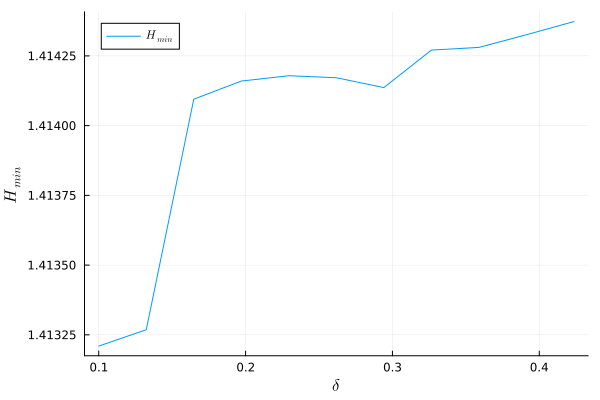

In [48]:
p = plot(δs, -log2.(pgs_22_wtilted), label="\$H_{min}\$")# for \$v=$(round(vs[end], digits=3))\$")
#for i in [13,15,17,18,19,20]
#    plot!(p, γs, -log2.(pgs_wtilted2[i,:]), label="\$H_{min}\$ for \$v=$(round(vs[i], digits=3))\$")
#end
xlabel!("\$\\delta\$")
ylabel!("\$H_{min}\$")
#savefig(p, "plots/hmin_vs_δ_bilo22_eve$ebits.svg")
p

## 24 Case

In [8]:
PA = projector('A', 1:2, 1:2, full=true)
PB = projector('B', 1:4, 1:2, full=true)
PC = projector('C', 1:2, 1:2, full=true)
PE2 = projector('D', 1:4, 1, full=true) # Eve guessing AC
PE4 = projector('D', 1:16, 1, full=true) # Eve guessing ABC

# Define scalar variables
con = separability_structure(["A", "B", "C", "D"], ("A","C"));
vars = generate_projective_scvar(PA, 5, swapped=true)#, var_symbols=("α","β"))
se = ScalarExtension(vars, con)

ScalarExtension(Dict{Monomial, Monomial}(PA1|2 PA1|1 => <PA1|2 PA1|1>, PA1|2 PA1|1 PA1|2 PA1|1 PA1|2 => <PA1|2 PA1|1 PA1|2 PA1|1 PA1|2>, PA1|1 PA1|2 PA1|1 PA1|2 PA1|1 => <PA1|1 PA1|2 PA1|1 PA1|2 PA1|1>, PA1|2 PA1|1 PA1|2 => <PA1|2 PA1|1 PA1|2>, PA1|1 PA1|2 PA1|1 PA1|2 => <PA1|1 PA1|2 PA1|1 PA1|2>, PA1|1 PA1|2 PA1|1 => <PA1|1 PA1|2 PA1|1>, PA1|2 PA1|1 PA1|2 PA1|1 => <PA1|2 PA1|1 PA1|2 PA1|1>, PA1|1 PA1|2 => <PA1|1 PA1|2>), Set([(2, 4), (1, 2), (3, 4), (1, 4), (2, 3)]))

In [70]:
p = p_bilocality_24_chsh_rotBSM(π/8)
pg = bilo_pguess(p, PA, PB, PC, PE4, se, level=3, x=1, z=1, verbose=true)
-log2(pg)

Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 34736           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 685035)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - dual attempts          : 0     

0.25007821584836704

In [8]:
p = p_bilocality_24_wtiltedBSM(π/8, π/8, 0.0)
pg = bilo_pguess(p, PA, PB, PC, PE4, se, level=3, x=1, z=1, verbose=true)
-log2(pg)

Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 34736           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 685035)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - dual attempts          : 0     

0.12520004754484726

#### Titlted strategy

In [ ]:
N, M = 10, 10
δ_interval = [0.1, π/6-.1]
φ_interval = [0, π/2]
level = 3
#PE = PE2
PE = PE4
ebits = Int(log2(size(PE)[1]))

δs = collect(δ_interval[1]:(δ_interval[2]-δ_interval[1])/N:δ_interval[2])
φs = collect(φ_interval[1]:(φ_interval[2]-φ_interval[1])/M:φ_interval[2])
pgs_24_tiltedBSM1 = ones((length(δs),length(φs)))

for ((i,δ), (j,φ)) ∈ collect(Iterators.product(enumerate(δs), enumerate(φs)))
    p = p_bilocality_24_wtiltedBSM(δ, π/8, φ)
    pg = bilo_pguess(p, PA, PB, PC, PE, se; level=level, x=1, z=1)
    print("\r δ = $δ\tφ = $φ\tPg = $pg")
    pgs_24_tiltedBSM1[i,j] = pg
end

 δ = 0.32651914291880924	φ = 0.0	Pg = 0.12518067327149984

In [ ]:
ebits = Int(log2(size(PE)[1]))
open("data/pguess_vs_δφ_bilo24_eve$(ebits)_npa$(level)_x1y1_phase.txt", "w") do io
    writedlm(io, [pgs_24_tiltedBSM1, δs, φs])
end

In [ ]:
maximum(-log2.(pgs_24_tiltedBSM1))

In [9]:
N = 10
v_interval = [0.7, 1]

vs = collect(v_interval[1]:(v_interval[2]-v_interval[1])/N:v_interval[2])

11-element Vector{Float64}:
 0.7
 0.73
 0.76
 0.79
 0.82
 0.85
 0.88
 0.91
 0.94
 0.97
 1.0

In [10]:
N = 20
v_interval = [0.7, 1]

vs = collect(v_interval[1]:(v_interval[2]-v_interval[1])/N:v_interval[2])

21-element Vector{Float64}:
 0.7
 0.715
 0.73
 0.745
 0.76
 0.7749999999999999
 0.79
 0.8049999999999999
 0.82
 0.835
 0.85
 0.865
 0.88
 0.895
 0.91
 0.925
 0.94
 0.9550000000000001
 0.97
 0.985
 1.0

In [11]:
N = 10
v_interval = [0.7, 1]
level = 3
#PE = PE2
PE = PE4
ebits = Int(log2(size(PE)[1]))

#vs = collect(v_interval[1]:(v_interval[2]-v_interval[1])/N:v_interval[2])
vs = [0.895, 0.925, 0.955, 0.985]
pgs_24_tiltedBSM1 = ones(length(vs))

@threads for (i,v) ∈ collect(enumerate(vs))
    p = p_bilocality_24_wtiltedBSM(π/6, π/8, 0.0, v=v)
    pg = bilo_pguess(p, PA, PB, PC, PE, se; level=level, x=1, y=1, z=1)
    print("\rv = $v\tPg = $pg")
    pgs_24_tiltedBSM1[i] = pg
end

v = 0.985	Pg = 0.4011086544496689

In [12]:
pgs_24_tiltedBSM1

4-element Vector{Float64}:
 0.9246166686535903
 0.8139384923280498
 0.6593736105868381
 0.4011086544496689

In [15]:
open("data/pguess_vs_v_bilo24-θπ8-δπ6_eve4_npa3_x1y1z1.txt", "r") do io
    (pgs_old, vs_old) = readdlm(io)
end

2×11 Matrix{Float64}:
 1.0  1.0   1.0   1.0   1.0   0.997871  …  0.743637  0.55059  0.12521
 0.7  0.73  0.76  0.79  0.82  0.85         0.94      0.97     1.0

In [ ]:
ebits = Int(log2(size(PE)[1]))
open("data/pguess_vs_v_bilo24-θπ9-δπ8_eve$(ebits)_npa$(level)_x1y1z1.txt", "w") do io
    writedlm(io, [pgs_24_tiltedBSM1, vs])
end

In [27]:
#pgs_24_tBSMθ = [copy(pgs_24_tiltedBSM1)]
push!(pgs_24_tBSMθ, copy(pgs_24_tiltedBSM1))
Hmin_24_tBSMθ = map(p->-log2.(p), pgs_24_tBSMθ)

4-element Vector{Vector{Float64}}:
 [-1.9331717922442362e-11, -5.672067454364662e-8, -2.8476219220080914e-11, -2.653318671699209e-8, 0.0003220418217813328, 0.007387426205288244, 0.05843602121645931, 0.19795412725694245, 0.45011748756999514, 0.9326193309887655, 2.9976929847517964]
 [-2.8459176988554666e-10, -1.1404438606061316e-9, -1.893080909437741e-10, -4.6126641092652775e-9, -3.2503374811706387e-10, 9.906470083019324e-6, 0.023952926058888463, 0.1305685192263631, 0.3471626072085615, 0.7502919925208142, 2.9967822283837506]
 [-7.559196617316727e-9, -8.281698067705885e-9, -1.6500849921141205e-12, -8.012657517426957e-8, -5.578348973251179e-8, 0.0030746353892811963, 0.052052572991792535, 0.19374310736519765, 0.4273301905533776, 0.8609494382216718, 2.997578976449448]
 [-4.587186938019019e-9, -6.138446131227623e-8, -4.12641472035333e-9, -5.256355417077611e-8, 0.0006754462247450998, 0.011579299725332587, 0.06272510634010317, 0.2031256329395349, 0.45870736858493305, 0.947027971573792, 2.997917

#### Plot

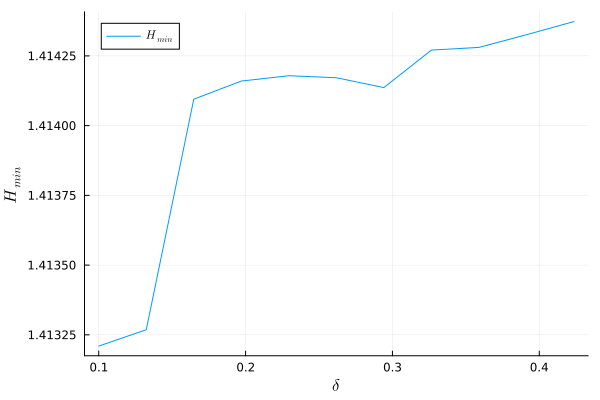

In [48]:
p = plot(δs, -log2.(pgs_22_wtilted), label="\$H_{min}\$")# for \$v=$(round(vs[end], digits=3))\$")
#for i in [13,15,17,18,19,20]
#    plot!(p, γs, -log2.(pgs_wtilted2[i,:]), label="\$H_{min}\$ for \$v=$(round(vs[i], digits=3))\$")
#end
xlabel!("\$\\delta\$")
ylabel!("\$H_{min}\$")
#savefig(p, "plots/hmin_vs_δ_bilo22_eve$ebits.svg")
p

In [70]:
using NPZ

## Paper Plots

## Figure 2 - simulations

### Panel (a) - Case 14, single Eve

In [ ]:
p = plot(vs3, -log2.(pgs3), label="\$H_{min}\$", markershape=:circle)

### Panel (a) - Case 22, single Eve

## Figure 4 - Experimental Data

In [ ]:
exp_data = npzread("data/exp_data/Punti_exp.npz")

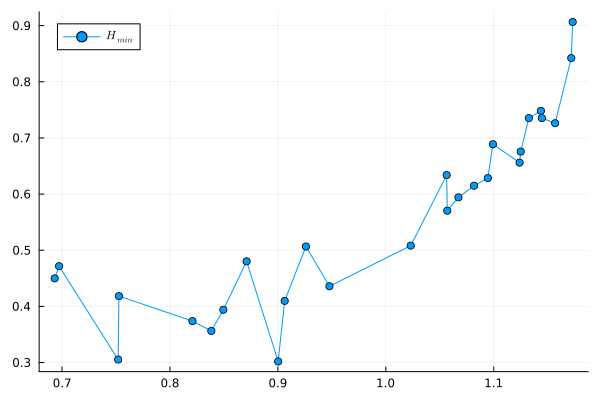

In [67]:
p = plot(viol, -log2.(pgs), label="\$H_{min}\$", markershape=:circle)